## CHAVEZ BECERRA Cristian Alejandro

## Practical Session - Unsupervised Learning

This Practical session is about unsupervised learning. We will use the dimensionality reduction and clustering techniques presented this morning to analyze both toy examples and real images.

Please answer the questions and complete the code where you see (`XXXXXXXXXX`). 

First let's load the functions we will use

In [3]:
import numpy as np
import numpy.matlib
import math
import matplotlib.pyplot as plt
plt.close('all')

from sklearn.model_selection import train_test_split
from sklearn.neighbors import KNeighborsClassifier
from sklearn.decomposition import NMF
from sklearn.cluster import KMeans
from sklearn.decomposition import PCA
from sklearn.decomposition import FastICA

from scipy import linalg as LA
from scipy.stats import ortho_group
from scipy.stats import gennorm

from skimage.io import imread
from skimage.transform import resize
from skimage.transform import rescale
from skimage import img_as_bool

from mpl_toolkits.axes_grid1 import AxesGrid
from scipy.spatial.distance import dice
from skimage.measure import find_contours

from scipy.io import loadmat

# I - Dimensionnality reduction: NMF

## I - 1) Dataset

You will first work on the same face images as during the practical work 1.

Load the original images present in the files *'YaleB\_32x32.mat'*. This is a small part of the freely available Extended Yale Face Database B downloaded from http://www.cad.zju.edu.cn/home/dengcai/Data/FaceData.html. It contains 2414 cropped images resized to 32x32 pixels. Every image is represented as a vector 1x1024 and all images are stacked in a matrix called data. There are 38 subjects with around 64 near frontal images per individual under different illumination conditions. Once loaded and normalised the data, such that the pixels are between 0 and 1, you can plot images using the function *'imshow'*.

**Goal**

The goal of this part is to evaluate the performance of the dimensionality reduction techniques presented this morning for face recognition. We divide the data-set into two parts, training and test. For every dimensionality reduction technique, you will first extract a set of basis images from your training data-set. Then, you will project the test subjects in this new basis and use the nearest neighbor algorithm to evaluate the performance of the dimensionality reduction technique. 

Let's load the data and define a function to plot the faces. If you do not remember how the dataset is constituted, please refer to the previous practical work.

In [4]:
if 'google.colab' in str(get_ipython()):
  from google_drive_downloader import GoogleDriveDownloader as gdd
  gdd.download_file_from_google_drive(file_id='1rgICXtcIAgDqSoHnNXNZMD_iNABF3RZA',
  dest_path='./YaleB_32x32.mat')
else:
  print('You are not using Colab. Please define working_dir with the absolute path to the folder where you downloaded the data')

# Please modify working_dir only if you are using your Anaconda (and not Google Colab)
Working_directory="./"




x = loadmat(Working_directory + './YaleB_32x32.mat')
data=x['fea']
d=data.shape[1] # number of pixels of the images
subjectIndex=x['gnd'] # we have one index per subject
maxValue = np.max(np.max(data)) # max intensity value
data = data/maxValue; # Scale pixels to [0,1]

Ns=len(np.unique(subjectIndex)); # Number subjects
Is=round(len(subjectIndex)/Ns) # Number images per subject (on average, not the same number for every subject)
r=int(np.sqrt(d)) # number rows of each image
c=r # number columns of each image, equal to row since images are square

print('There are', data.shape[0], 'facial images and each image has', d, 'pixels' )
print('There are', Ns, 'different subjects and each subject has on average', Is, 'images')




Xtrain, Xtest, Id_Train, Id_Test = train_test_split(data,subjectIndex,test_size=0.20,stratify=subjectIndex, random_state=44)
Xctest=Xtest-np.mean(Xtest,axis=0) # centering
Xctrain=Xtrain-np.mean(Xtrain,axis=0) # centering



def plotFaces(data,r,c,ncol=2,N=0,indeces=None,title=None):
    # data: each face is a row in data
    # r,c = number of rows and columns of each image
    # n_col = number of columns for subplots
    # N = random images to plot (used only if indeces is empty)
    # indeces = indeces of images to plot
    # title = title of the plot

   
    if indeces is None:
        if N==0:
            raise NameError('You should define either N or indeces')
        else:
            print('Use N random subjects')
            indeces=np.random.randint(0,data.shape[0],(N,1))
            
    nrow=math.ceil(len(indeces)/ncol)
    
    fig=plt.figure(figsize=(17, 6))
    plt.suptitle(title, size=16)
    for i, index in enumerate(indeces):
        fig.add_subplot(nrow, ncol, i+1)
        plt.imshow(np.resize(data[index,:],(r,c)).T,origin='upper',cmap='gray')
        plt.xticks(())
        plt.yticks(())

You are not using Colab. Please define working_dir with the absolute path to the folder where you downloaded the data
There are 2414 facial images and each image has 1024 pixels
There are 38 different subjects and each subject has on average 64 images


## I - 2) NMF

Here you will test Non-negative Matrix factorization. The basis images of the training are in the matrix $W_{train}$ and the scores (or coefficients) to test the performance in $H_{train}$. The test scores are computed as $H_{test}=W_{train}^{-1}X_{test}$.

**Question**

1. Use the scikit-learn implementation to test the performance.
2. Plot the basis images and compare them with respect to the basis images obtained using PCA and ICA in the last practical work. What can you say ?
3. What about the performances of NMF, i.e. computational time and classification accuracy ?
4. Do you think that it is a good idea to use a PCA before the NMF algorithm? Why?

**Answers**

2. Compared to the rsults obtained in PCA and ICA we can appreciate that NMF basis images represent parts-based representations of the data, that means, more localized so they resemble parts of the original images, such as edges, textures, or shapes. In contrast to, for example, PCA that capture global patterns

3. We have better classification accuracy, this may be because for NMF there is no assumption about the distribution of the data, so that is more general in this way than ICA and PCA. It may be also because negative values do not appear in the original data and do not make sense physically. However PCA or ICA factorizations often produce negative components. But, it takes more time compared to PCA whose complexity is $O(n^3)$

4. It will depend in the case since PCA and NMF use different assumptions. Nevertheless, using PCA before applying NMF can be beneficial in certain scenarios. PCA helps in reducing the dimensionality of the data by capturing the directions of maximum variance. This can help NMF by providing a more compact representation of the data, potentially leading to faster convergence and better performance. Additionally, PCA can help in removing noise and irrelevant features from the data, which can improve the quality of the input to NMF.

NMF uses  100  features
Percentage of correct answer using NMF is  0.8737060041407867


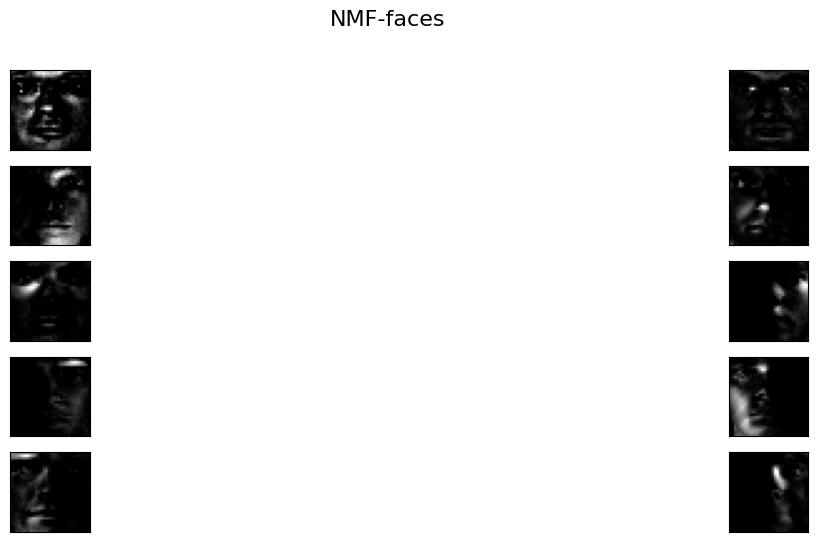

In [20]:
# NMF (scikit-learn implementation)
Ncomponents=100
model = NMF(init='random', solver='mu', n_components=Ncomponents, tol=1e-3,max_iter=300, random_state=0)
WtrainNNMF = model.fit_transform(Xtrain.T)
HtrainNNMF = model.components_

plotFaces(WtrainNNMF.T,r,c,ncol=2,indeces=np.arange(0,10,1),title='NMF-faces')

# to invert the matrix you can use the function LA.pinv
Htest_nnmf = np.dot(LA.pinv(WtrainNNMF),Xtest.T)

print('NMF uses ', Ncomponents, ' features')

# Score
NN=KNeighborsClassifier(n_neighbors=1)
NN.fit(HtrainNNMF.T,Id_Train.ravel())
print('Percentage of correct answer using NMF is ', NN.score(Htest_nnmf.T,Id_Test))

Implement your own implementation in `NNMFLecture` following the lecture slides. Complete the missing lines (`XXXXXXXXXX`) 

In [21]:
def NNMFLecture(X,r=None,N_Iter=1000,tolerance=1e-3,plot_evolution=1):
    '''
    Inputs: 
    %           X: is a [dxN] matrix. Every column (x) is an observation and every
    %           row consists of features.
    %
    %           r: size of the matrices W and H
    %
    %           (Optional) N_Iter: maximum number of iterations
    %
    %           (Optional) tolerance: convergence criteria threshold
    %
    %           (Optional) plot_evolution: plot evolution convergence criteria
    %
    % Outputs:
    %           W: is a [d x r] matrix containing the basis images in its
    %           columns
    %           
    %           H: is a [r x N] matrix containing the loadings (h) in its columns
    %           of the linear combination: x=Wh 
    %
  '''
    if r is None:
        r=X.shape[0]
        
    # Test for positive values
    if np.min(X) < 0:
        raise NameError('Input matrix X has negative values !')      

    # Size
    d,N=X.shape
   
    # Initialization
    #W=XXXXXXXX
    #H=XXXXXXXX   
    # Initialization
    W=np.random.rand(d, r)
    H=np.random.rand(r, N)   
    
    # parameters for convergence
    k = 0
    delta = np.inf
    eps=np.finfo(float).eps
    evolutionDelta=[]
 
    while delta > tolerance and k < N_Iter:
        
        # multiplicative method      
        
        XH=np.dot(X,H.T)
        HH=np.dot(H,H.T)
        for i in range(20):
            #W = np.divide(XXXXXXXX + eps)
            W = np.divide(np.multiply(W, XH), W@HH + eps)
                       
        #H = np.divide(XXXXXXXX + eps)
        #H = np.divide(np.dot(W.T, X), np.dot(np.dot(W.T, W), H) + eps)
        H = np.divide(np.multiply(H, W.T@X), W.T@W@H + eps)


        # Convergence indices
        k = k + 1           
        diff=X-np.dot(W,H)     
        #delta = np.sqrt(np.sum(diff**2)) / np.sqrt(np.sum(X**2)) # |X-WH|_2 / |X|_2
        delta = LA.norm(diff,'fro') / LA.norm(X,'fro') # sqrt(trace(diff'*diff)) / sqrt(trace(X'*X))
        evolutionDelta.append(delta)
        
        if k==1 or k%100==0:
            print('Iteration NMF number ', k, ' out of ', N_Iter , ', delta = ', delta, ', error (norm delta): ', LA.norm(diff))
     
    if k==N_Iter:
        print('Maximum number of iterations reached ! delta = ', delta)
    else:
        print('Convergence achieved ( delta = ', delta, ') in ', k, ' iterations')
    
    if plot_evolution==1:
        plt.figure(figsize=(6, 6))
        plt.plot(range(k),evolutionDelta,'bx--', linewidth=4, markersize=12)  
        plt.title('Evolution of error - NMF')
        plt.show()
    
    return W,H

Iteration NMF number  1  out of  300 , delta =  0.5320415457646599 , error (norm delta):  273.8720448000431
Iteration NMF number  100  out of  300 , delta =  0.15862019892393758 , error (norm delta):  81.65083830709736
Iteration NMF number  200  out of  300 , delta =  0.15112563005791702 , error (norm delta):  77.79295743938837
Iteration NMF number  300  out of  300 , delta =  0.14874251090391663 , error (norm delta):  76.56623046495595
Maximum number of iterations reached ! delta =  0.14874251090391663


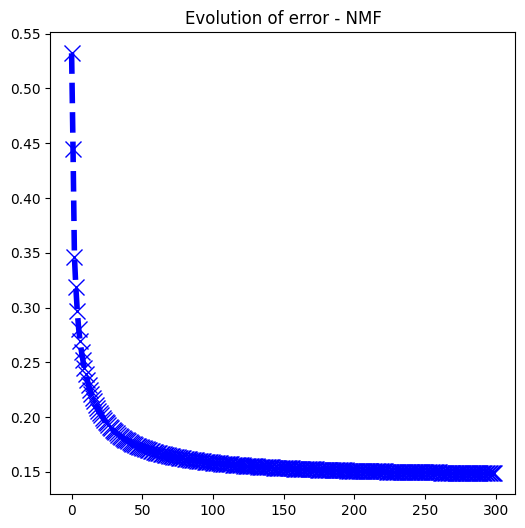

NMF uses  100  features
Percentage of correct answer using NMF is  0.865424430641822


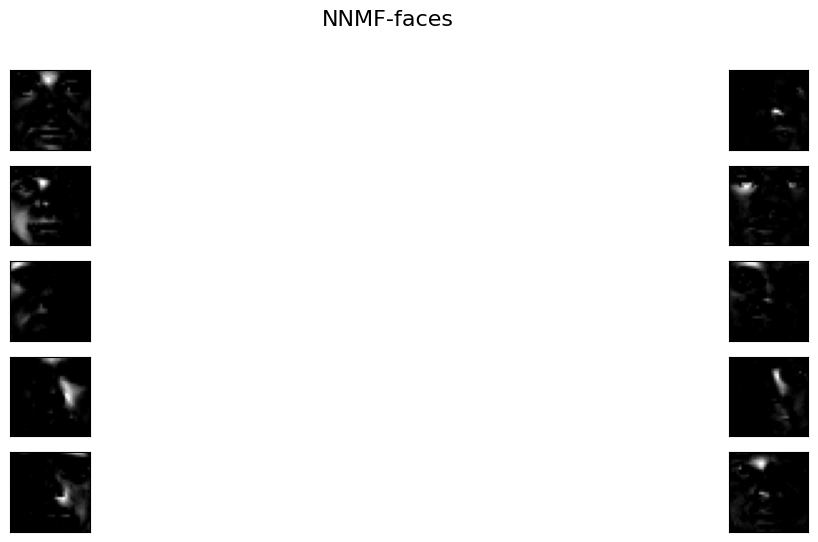

In [22]:
# NMF (your own implementation)
Ncomponents=100
Wtrain_nnmf,Htrain_nnmf = NNMFLecture(Xtrain.T,r=Ncomponents,N_Iter=300,tolerance=1e-3,plot_evolution=1)
plotFaces(Wtrain_nnmf.T,r,c,ncol=2,indeces=np.arange(0,10,1),title='NNMF-faces') 

# to invert the matrix you can use the function LA.pinv
Htest_nnmf = np.dot(LA.pinv(Wtrain_nnmf),Xtest.T)

print('NMF uses ', Ncomponents, ' features')

# Score
NN.fit(Htrain_nnmf.T,Id_Train.ravel())
print('Percentage of correct answer using NMF is ', NN.score(Htest_nnmf.T,Id_Test))

- What do you observe? We can observer that the basis images gotten from our implementation are a little bit different from the one of the library, but still have similar features
- What is the limitation of doing an inversion for Htest_nnmf? How would you avoid that?
That Htest_nnmf may be ill-conditioned or nearly singular, so that, its inverse may amplify numerical errors, leading to inaccurate or unstable results.
Also if Htest_nnmf becomes singular, (so it doesn't have a full rank), it cannot be inverted directly.

A possible way to avoid this is using instead the pseudo-inverse

## I-3) ICA and NMF in the presence of noise

We will now compare ICA and NMF results in the presence of noise within the dataset. Please note that during the class on ICA, the dataset $X$ was assumed to be noiseless: we were looking for a decomposition such that $X = AS$, and not $X = AS + N$, where $N$ would be a noise term.

1. How do you think that ICA might behave in the presence of noise? You might in particular consider the case of a Gaussian noise N.
2. On the other hand, do you think that NMF behaves better? If so, for what kind of noises?

In the following, we will try to compare the behavior of ICA and NMF in the presence of noise. Do the following:
- add some Gaussian noise to both the training and the testing dataset.
- apply both NMF and ICA (the second architecture you implemented in the previous practical work) on the noisy dataset. For both, you can use 250 features.
- use the NN algorithm to classify the images from the features extracted from ICA and NMF.

Redo the same for different noise levels. Plot a curve of the classification accuracy when either ICA or NMF are used as pre-processing steps. Comment your results.

**Answers**
1. Since the presence of noise implies that the relation between the observed data and the estimates of the independent components is non-linear, ICA may not behave pretty well (without taking account aproximations). Also, since ICA aims to separate a mixed signal into statistically independent source signals, in the presence of noise, it  may struggle to properly separate the sources from the noise.
If the noise is Gaussian and independent of the signal, ICA might still be able to partially separate the sources, but the noise may contaminate the estimated sources, leading to not the best performance.

2. IN NMF already take into acocunt that may exist some noise, so it's gonna perform better than PCA or ICA, it will work better for additive Gaussian noise

C:\Users\aleja\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.9_qbz5n2kfra8p0\LocalCache\local-packages\Python39\site-packages\sklearn\decomposition\_nmf.py:1770: ConvergenceWarning: Maximum number of iterations 300 reached. Increase it to improve convergence.
  warnings.warn(


NNMF uses  250  features
Percentage of correct answer using NNMF is  0.8881987577639752
ICA uses  250  features
Percentage of correct answer using ICA is  0.9213250517598344
NNMF uses  250  features
Percentage of correct answer using NNMF is  0.8799171842650103
ICA uses  250  features
Percentage of correct answer using ICA is  0.8716356107660456
NNMF uses  250  features
Percentage of correct answer using NNMF is  0.8385093167701864
ICA uses  250  features
Percentage of correct answer using ICA is  0.2650103519668737
NNMF uses  250  features
Percentage of correct answer using NNMF is  0.7349896480331263
ICA uses  250  features
Percentage of correct answer using ICA is  0.10351966873706005
NNMF uses  250  features
Percentage of correct answer using NNMF is  0.5031055900621118
ICA uses  250  features
Percentage of correct answer using ICA is  0.062111801242236024
NNMF uses  250  features
Percentage of correct answer using NNMF is  0.30434782608695654
ICA uses  250  features
Percentage of 

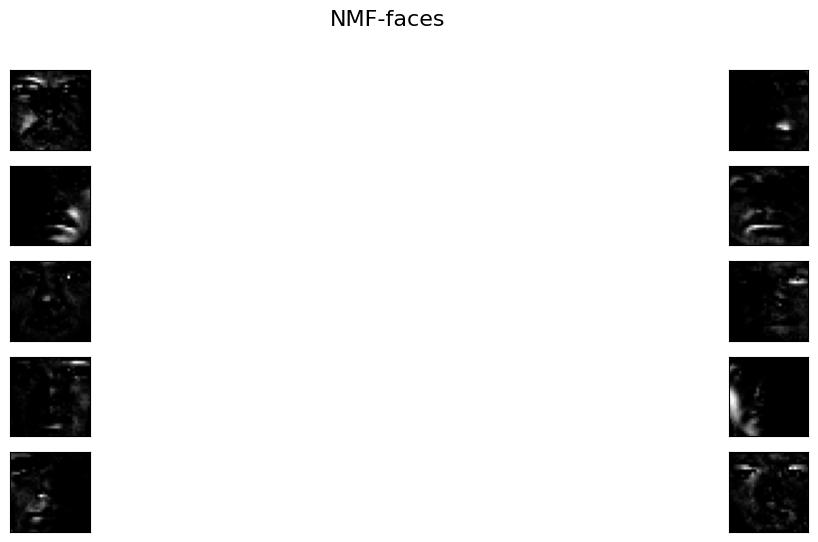

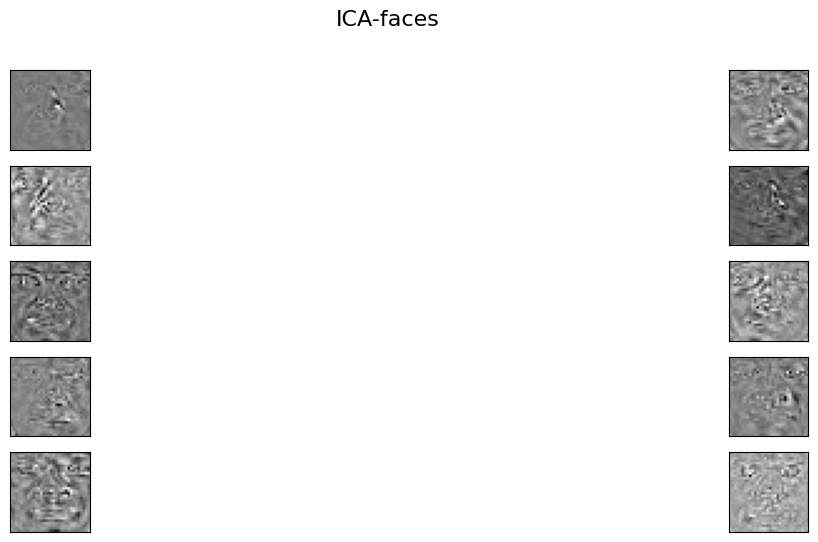

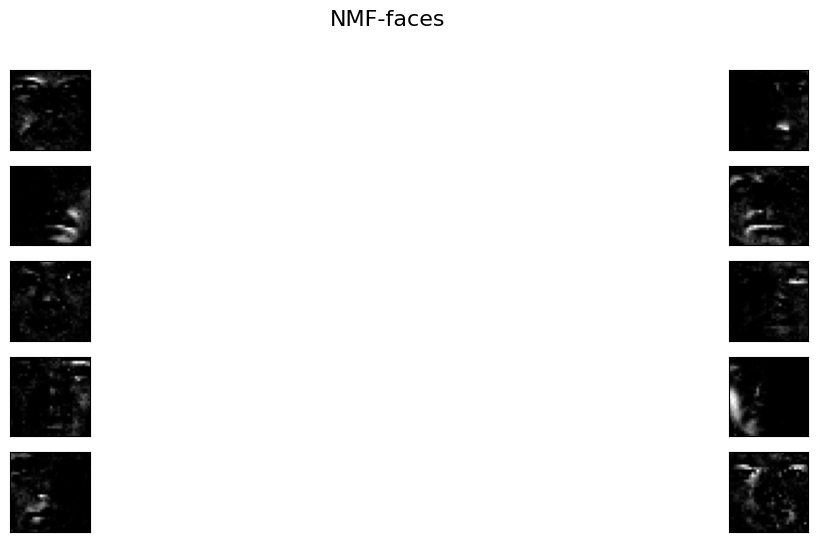

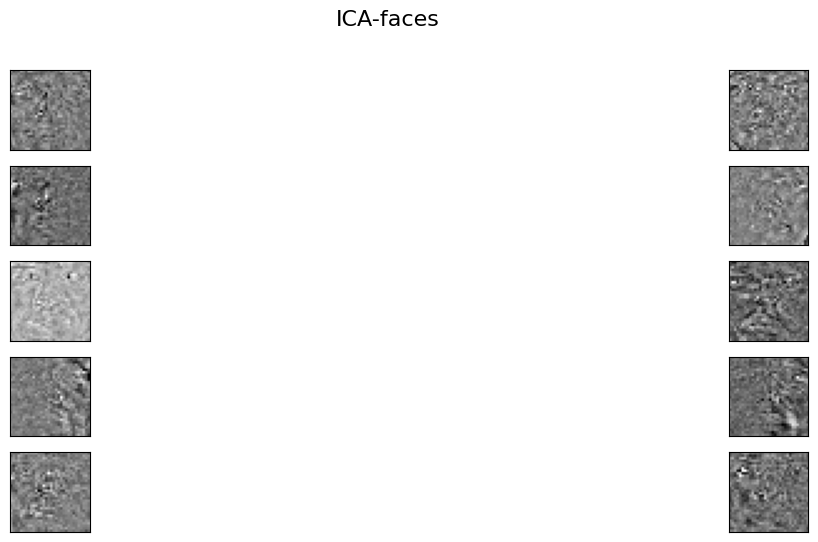

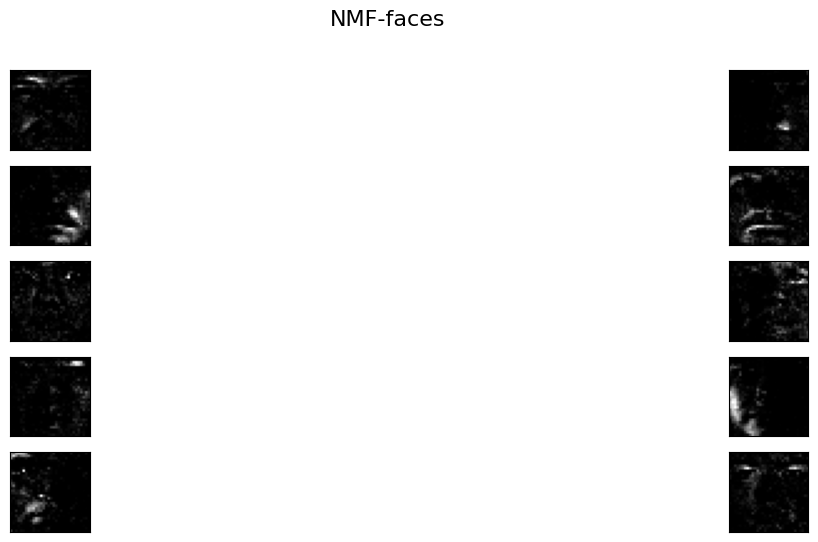

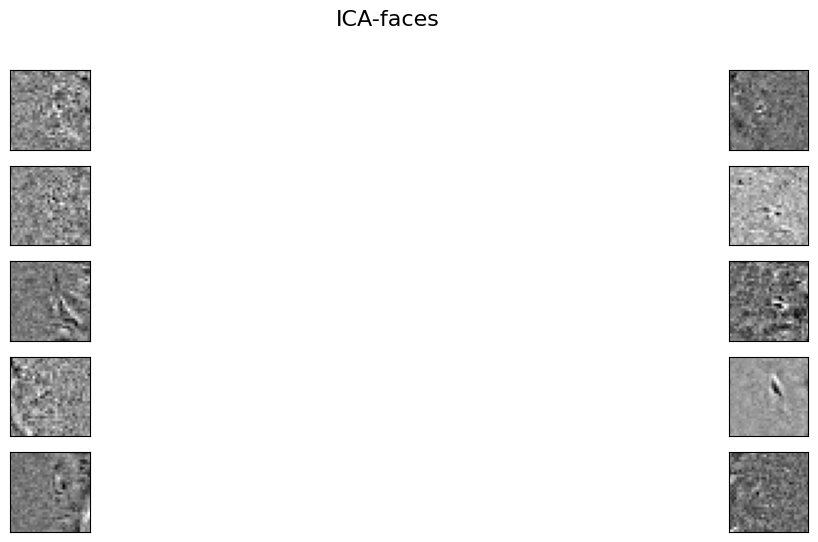

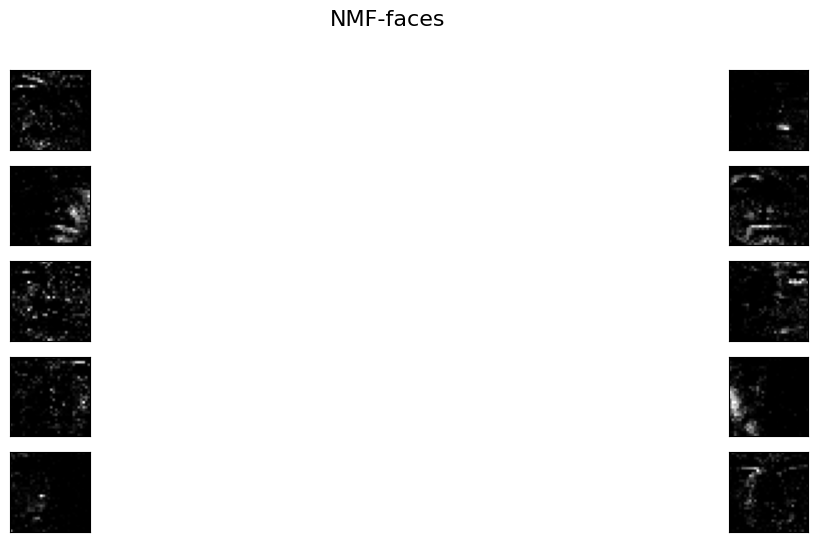

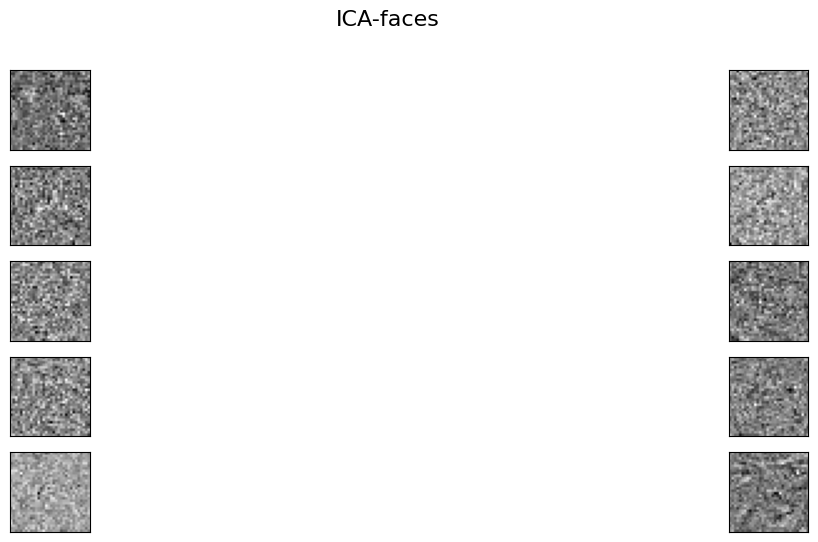

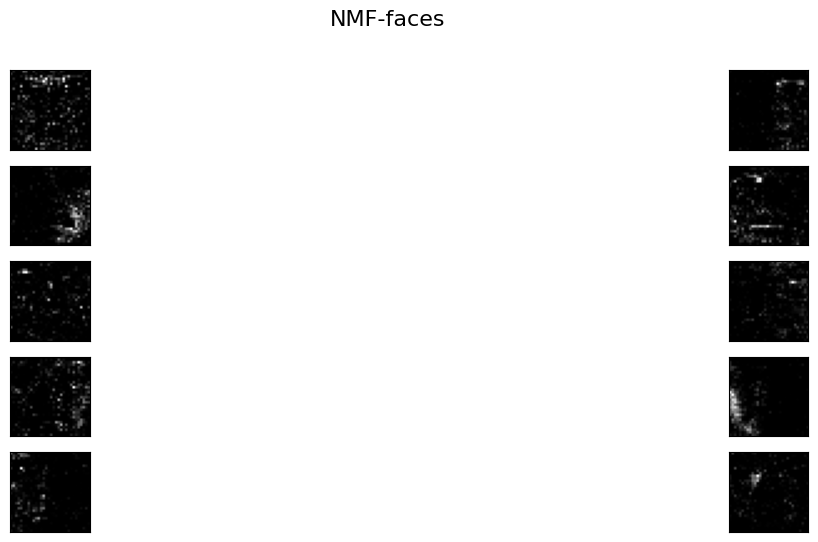

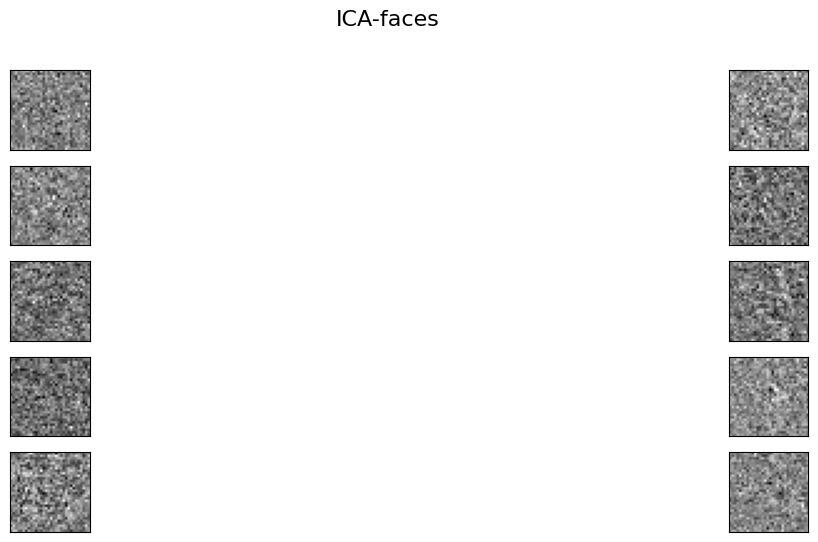

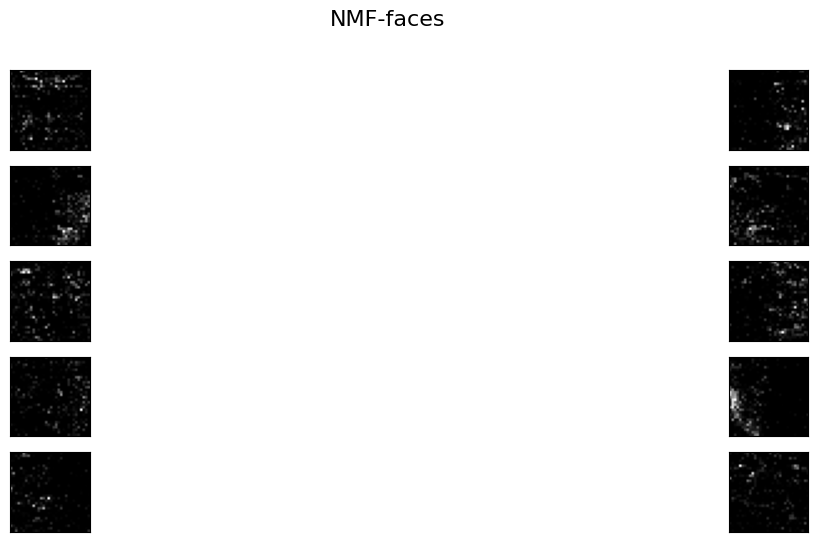

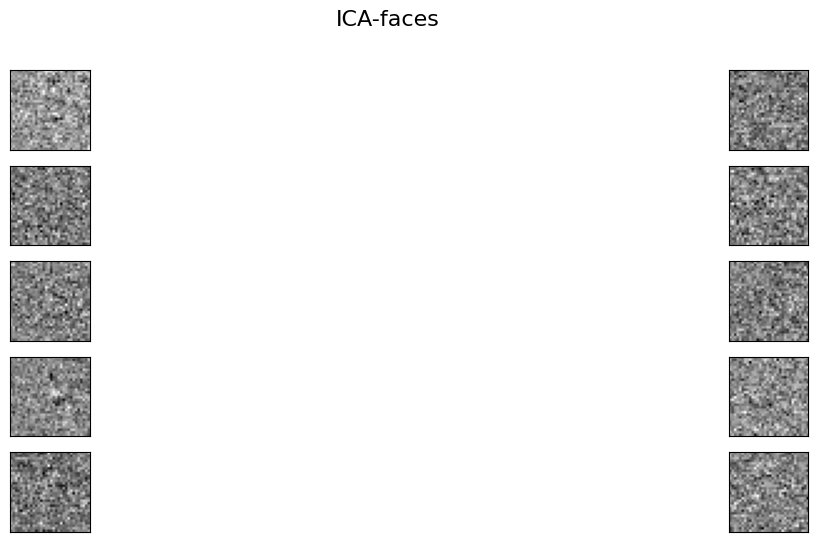

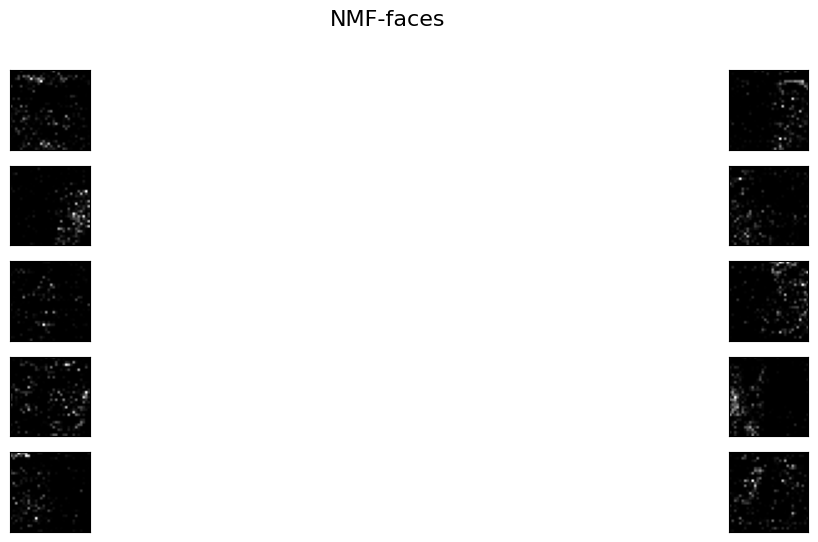

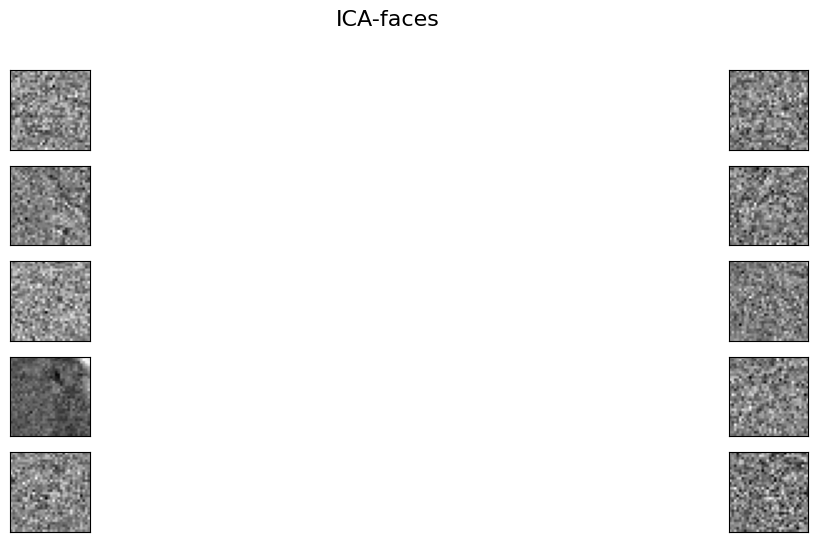

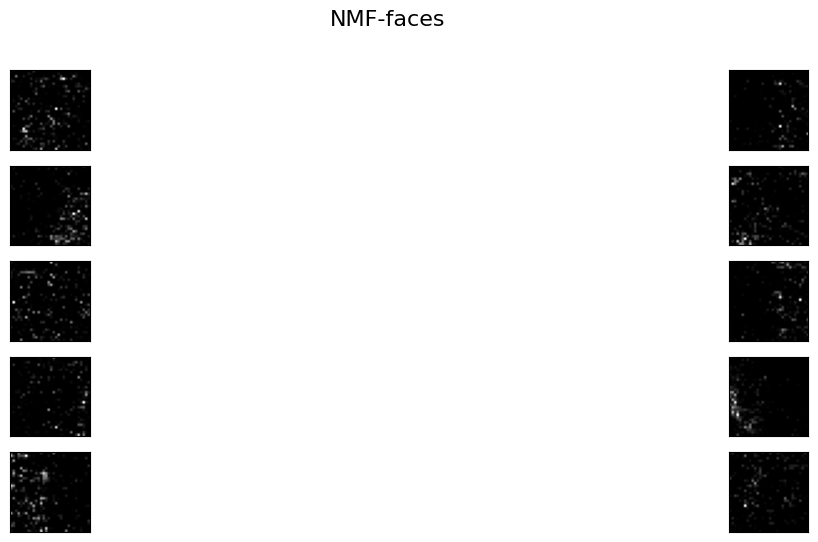

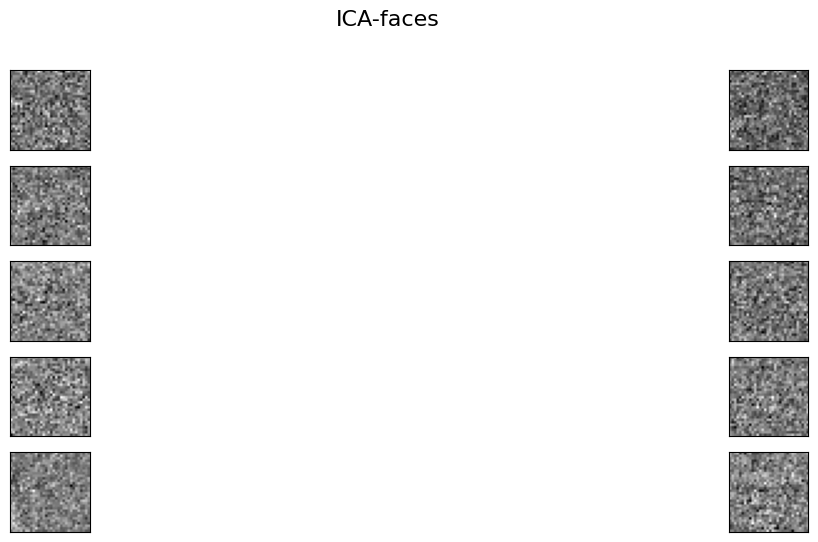

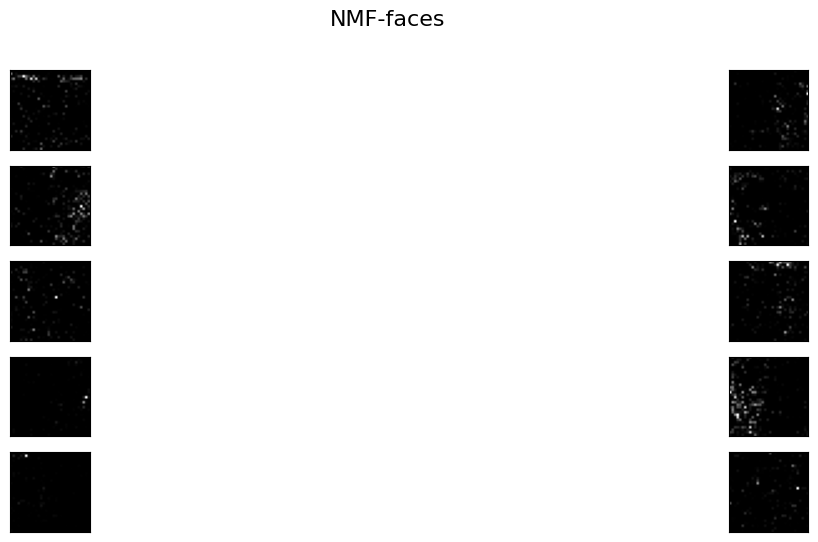

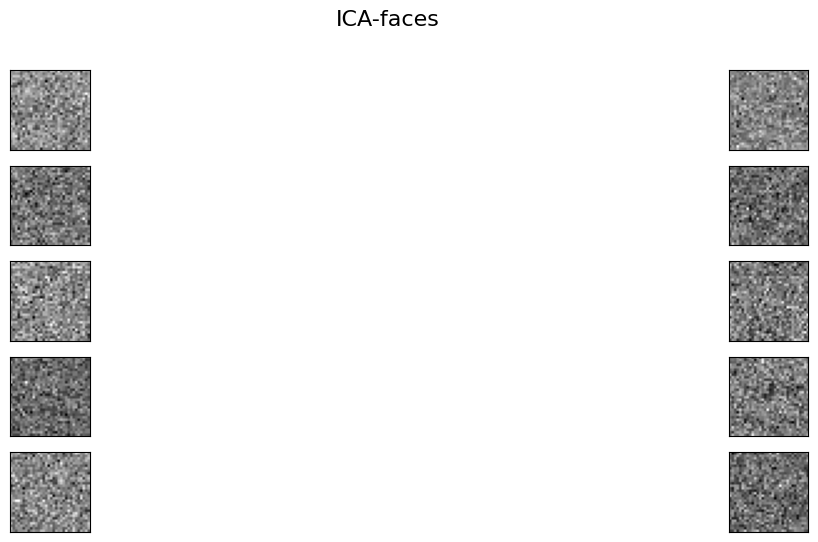

In [23]:
sigmaTab = np.array([0,0.05,0.1,0.15,0.2,0.25,0.3,0.4,0.5])
scoreNMF = np.zeros(len(sigmaTab))
scoreICA = np.zeros(len(sigmaTab))
scoreICA1 = np.zeros(len(sigmaTab))

for i in range(len(sigmaTab)):
    # Data generation
    #XXXXXXXX
    #XXXXXXXX
    #XXXXXXXX
    #XXXXXXXX
    #XXXXXXXX
    #XXXXXXXX
    noise_train = np.random.normal(0, sigmaTab[i], Xtrain.shape)
    noise_test = np.random.normal(0, sigmaTab[i], Xtest.shape)

    # Ensure non-negativity of the noisy datasets
    XtrainNoise = np.clip(Xtrain + noise_train, 0, None)
    XtestNoise = np.clip(Xtest + noise_test, 0, None)
    
    ##################
    # NMF
    Ncomponents=250
    model = NMF(init='random', solver='mu', n_components=Ncomponents, tol=1e-3,max_iter=300, random_state=0)
    WtrainNNMF = model.fit_transform(XtrainNoise.T)
    HtrainNNMF = model.components_

    plotFaces(WtrainNNMF.T,r,c,ncol=2,indeces=np.arange(0,10,1),title='NMF-faces') 
    # to invert the matrix you can use the function LA.pinv
    #Htest_nnmf = np.dot(XXXXXXXX,XtestNoise.T)
    Htest_nnmf = np.dot(np.linalg.pinv(WtrainNNMF), XtestNoise.T)

    print('NNMF uses ', Ncomponents, ' features')

    # Score
    NN=KNeighborsClassifier(n_neighbors=1)
    #NN.fit(XXXXXXXX,Id_Train.ravel())
	#estamos ingresando los pesos de la matriz HtrainNNMF
    NN.fit(HtrainNNMF.T, Id_Train.ravel())
    #print('Percentage of correct answer using NNMF is ', NN.score(XXXXXXXX,Id_Test))
    #scoreNMF[i] = XXXXXXXX
    print('Percentage of correct answer using NNMF is ', NN.score(Htest_nnmf.T, Id_Test))
    scoreNMF[i] = NN.score(Htest_nnmf.T, Id_Test)

    ##################
    ## ICA (you don't have anything to change here)
    # Second architecture (scikit-learn implementation)
    XctestNoise=XtestNoise-np.mean(XtestNoise,axis=0) # centering
    XctrainNoise=XtrainNoise-np.mean(XtrainNoise,axis=0) # centering
    
    # Second architecture (scikit-learn implementation).
    pca = PCA(random_state=1) 
    YpcaTrain=pca.fit_transform(XctrainNoise)
    UpcaTrain=pca.components_.T # we want PC on columns
    var_explained_pca=pca.explained_variance_ratio_

    # We use the PCA projection to speed up results
    PCAComp=250

    # Selection of the eigenvectors 
    Yr_train_PCA=YpcaTrain[:,:PCAComp]
    Ur_train_PCA=UpcaTrain[:,:PCAComp]
    Yr_test_PCA=np.dot(XctestNoise,Ur_train_PCA)

    ICA= FastICA(whiten='arbitrary-variance', fun='exp', max_iter=30000, tol=1e-4, algorithm='parallel', random_state=1)
    Yica=ICA.fit_transform(Yr_train_PCA)
    S_train_ICA=Yica.T
    W_train_ICA=ICA.components_

    ICAFAces=np.dot(Ur_train_PCA,W_train_ICA.T) 
    Y_train_ICA=S_train_ICA
    Y_test_ICA=np.dot(W_train_ICA,Yr_test_PCA.T)

    # Plot the ICA-faces
    plotFaces(ICAFAces.T,r,c,ncol=2,indeces=np.arange(0,10,1),title='ICA-faces')      

    print('ICA uses ', Y_train_ICA.shape[0], ' features')

    # Score ICA
    NN.fit(Y_train_ICA.T,Id_Train.ravel())
    #print('Percentage of correct answer using ICA is ', NN.score(XXXXXXXX,Id_Test.ravel()))
    #scoreICA[i] = NN.score(XXXXXXXX,Id_Test.ravel())
    print('Percentage of correct answer using ICA is ', NN.score(Y_test_ICA.T, Id_Test.ravel()))
    scoreICA[i] = NN.score(Y_test_ICA.T, Id_Test.ravel())

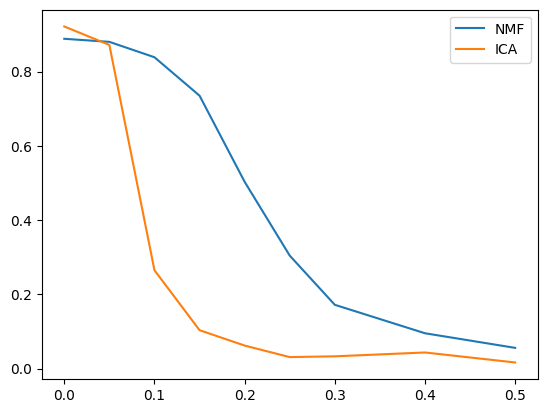

In [24]:
plt.figure(),plt.plot(sigmaTab,scoreNMF)
plt.plot(sigmaTab,scoreICA)
plt.legend(['NMF','ICA'])

# II - Clustering: K-means

We will now work on the K-means algorithm. First, the K-means algorithm will be used to cluster the toy examples datasets of the first practical work. Then, it will be used to segment real images.

## II - 1) Toy examples

Let us first define the toy examples.

In [5]:
def generate_scenario(scenario=3, n_samples0 = 100, n_samples1 = 30):

    y = np.concatenate((np.zeros([n_samples0,1]) , np.ones([n_samples1,1])) , axis=0)

    if scenario == 1: 
        # Separate Gaussian
        mean0 = [2, 3]
        mean1 = [12, 14]
        cov0 = [[1, 1.5], [1.5 ,3]]
        cov1 = 2 ** 2 * np.eye(2)
        X0 = np.random.multivariate_normal(mean0, cov0, n_samples0, check_valid='raise')
        X1 = np.random.multivariate_normal(mean1, cov1, n_samples1, check_valid='raise')
        
    elif scenario == 2:
        # Overlapping Gaussian
        mean0 = [2, 3]
        mean1 = [5, 7]
        cov0 = [[1, 1.5], [1.5 ,3]]
        cov1 = [[2, 3], [3 ,6]]
        X0 = np.random.multivariate_normal(mean0, cov0, n_samples0, check_valid='raise')
        X1 = np.random.multivariate_normal(mean1, cov1, n_samples1, check_valid='raise')
        
        
    elif scenario == 3:
        # Overlapping Gaussian
        mean0 = [0, 0]
        mean1 = [0, 0]
        cov0 = [[50, 15], [15, 6]]#cov0 = [[50, 4], [4, 2]]
        cov1 = [[2, 0], [0 ,50]]#cov1 = [[2, 0], [0 ,50]]
        X0 = np.random.multivariate_normal(mean0, cov0, n_samples0, check_valid='raise')
        X1 = np.random.multivariate_normal(mean1, cov1, n_samples1, check_valid='raise')
        
        
    elif scenario == 4:
        # Circles
        # 1 circle
        angle0=np.linspace(0, 2 * np.pi, n_samples0);
        X0=np.vstack((8*np.cos(angle0) , 8*np.sin(angle0))).T
        
        # 2 circle
        angle1=np.linspace(0, 2 * np.pi, n_samples1);
        X1=np.vstack((2*np.cos(angle1) , 2*np.sin(angle1))).T

    return X0,X1,y

def plotResults(X0=None,X1=None,y=None,U=None,Y=None,const=1,title=''):

    X=np.concatenate((X0,X1),axis=0)
    
    N0=np.sum(y==0)
    N1=np.sum(y==1)
    
    fig=plt.figure(figsize=(17, 6))
    
    ax  = fig.add_subplot(1, 3, 1)
    plt.scatter(X0[:,0],X0[:,1],c='r', label='Class 0')
    plt.scatter(X1[:,0],X1[:,1],c='b', label='Class 1')
    if U is not None:
        average=X.mean(axis=0)
        sd=LA.norm(X.std(axis=0))
        u0=U[:,0]*const*sd;
        u1=U[:,1]*const*sd;
        plt.plot([average[0]-u0[0], average[0]+u0[0]],[average[1]-u0[1], average[1]+u0[1]], c='g',linewidth=4, label='C 1' )
        plt.plot([average[0]-u1[0], average[0]+u1[0]],[average[1]-u1[1], average[1]+u1[1]], c='k',linewidth=4, label='C 2' )
        plt.title('Original data and components')
    else:
        plt.title('Original data')
    plt.legend()
    
    ax  = fig.add_subplot(1, 3, 2)
    plt.scatter(Y[np.where(y == 0)[0],0], np.zeros((N0,1)), c='r', s=3, marker='o', label='Class 0')
    plt.scatter(Y[np.where(y == 1)[0],0], np.zeros((N1,1)), c='b', s=3, marker='x', label='Class 1')
    ax.set_title(title + '\n Scores on 1st component')
    
    ax  = fig.add_subplot(1, 3, 3)
    plt.scatter(Y[np.where(y == 0)[0],1], np.zeros((N0,1)), c='r', s=3, marker='o', label='Class 0')
    plt.scatter(Y[np.where(y == 1)[0],1], np.zeros((N1,1)), c='b', s=3, marker='x', label='Class 1')
    plt.legend()
    plt.title('Scores on 2nd component')
    
    plt.show()
    
    
def frontiere(model, X, y, step=50):

    labels = np.unique(y)
 
    min_tot = np.min(X)
    max_tot = np.max(X)
    delta = (max_tot - min_tot) / step
    xx, yy = np.meshgrid(np.arange(min_tot, max_tot, delta),
                         np.arange(min_tot, max_tot, delta))
    z = np.array( model.predict(np.c_[xx.ravel(), yy.ravel() ]) )
    z = z.reshape(xx.shape)
   
    plt.imshow(z, origin='lower', extent=[min_tot, max_tot, min_tot, max_tot],
               interpolation="mitchell", cmap='RdBu')
    
    cbar = plt.colorbar(ticks=labels)
    cbar.ax.set_yticklabels(labels)

    plt.scatter(X[np.where(yKmeans == 0)[0],0],X[np.where(yKmeans == 0)[0],1],c='r', label='Predicted class 0')
    plt.scatter(X[np.where(yKmeans == 1)[0],0],X[np.where(yKmeans == 1)[0],1],c='b', label='Predicted class 1') 
    
    plt.ylim([min_tot, max_tot])
    plt.xlim([min_tot, max_tot])
    

Now, create the data we will use.

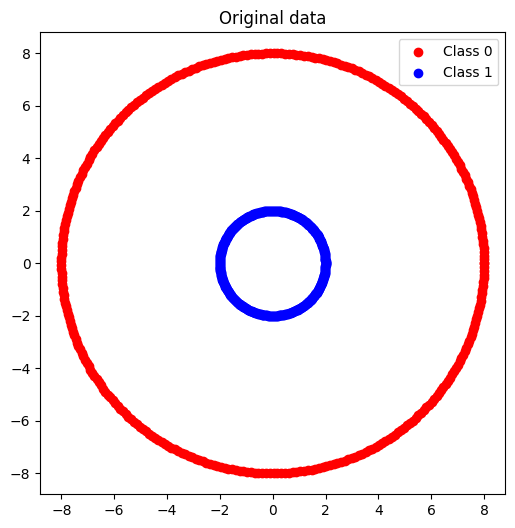

In [26]:
## Choose the scenarioIndex (value between 1 and 4)
scenarioIndex = 4
##

X0,X1,y = generate_scenario(scenario=scenarioIndex, n_samples0 = 350, n_samples1 = 350)
X=np.concatenate((X0,X1),axis=0)

plt.figure(figsize=(6, 6))
plt.scatter(X0[:,0],X0[:,1],c='r', label='Class 0')
plt.scatter(X1[:,0],X1[:,1],c='b', label='Class 1')
plt.title('Original data')
plt.legend()
plt.show()

Use the K-means to find the different clusters in the dataset. K-means will be used on X and we will check whether it can well separate the two classes. 


**Question:**
1. Does it work well in all scenarios ? Why ? Is it always easy to define the correct number of clusters ?

**Answer**

No, it does not behave well in the scenarios where one or mor eof the k-means assumptions is not present. For example, the assumption that clusters should be isotropic (spherical/Gaussian) is not presented in 2 and 3 scenarios, that's why it doesnt work.
For the scenario 4, k-means does not work since this scneario does not have the assumption that clusters should have similar variance (spatial extent)

It's not always easy to define the correct number of clusters, and less when we talk about of data of more than 3d. however there are techniques like the elbow method, to choose the number of clusters 



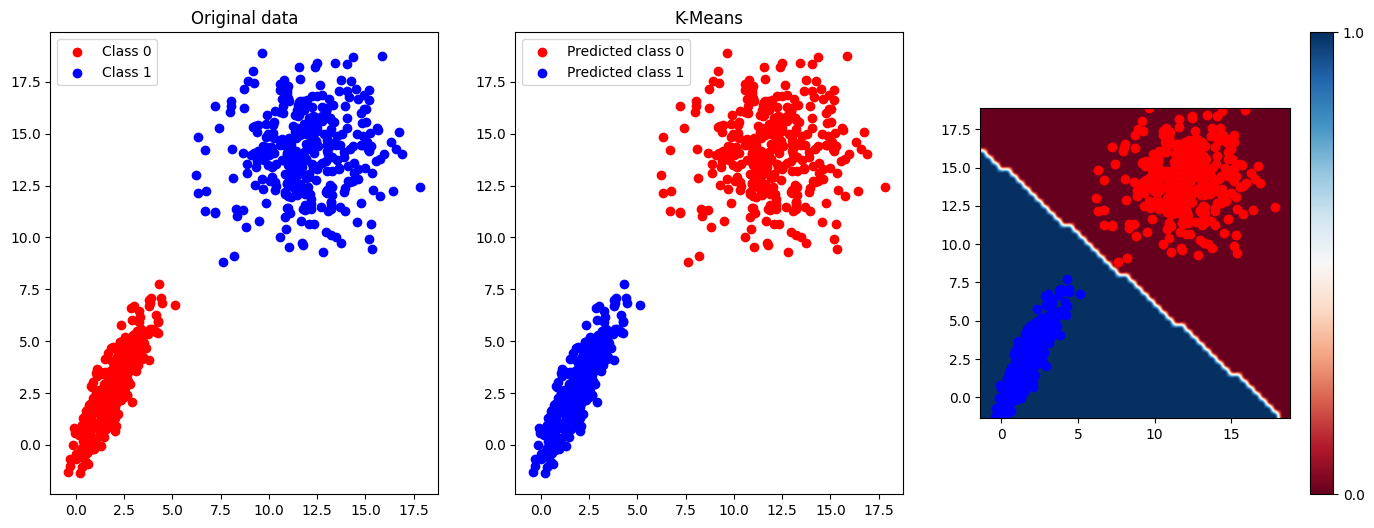

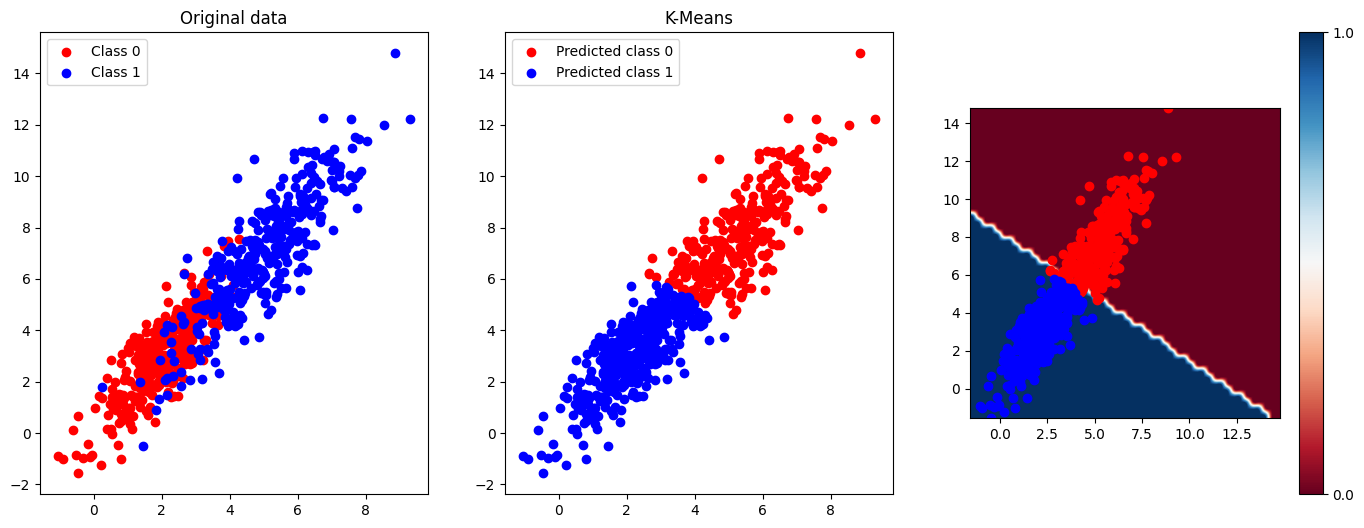

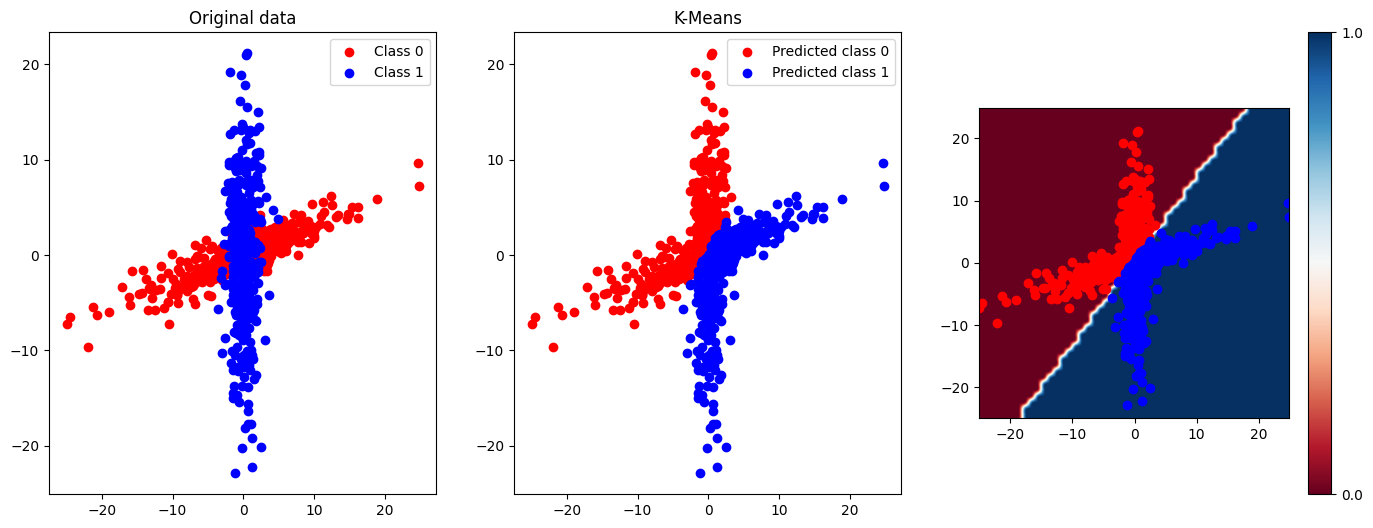

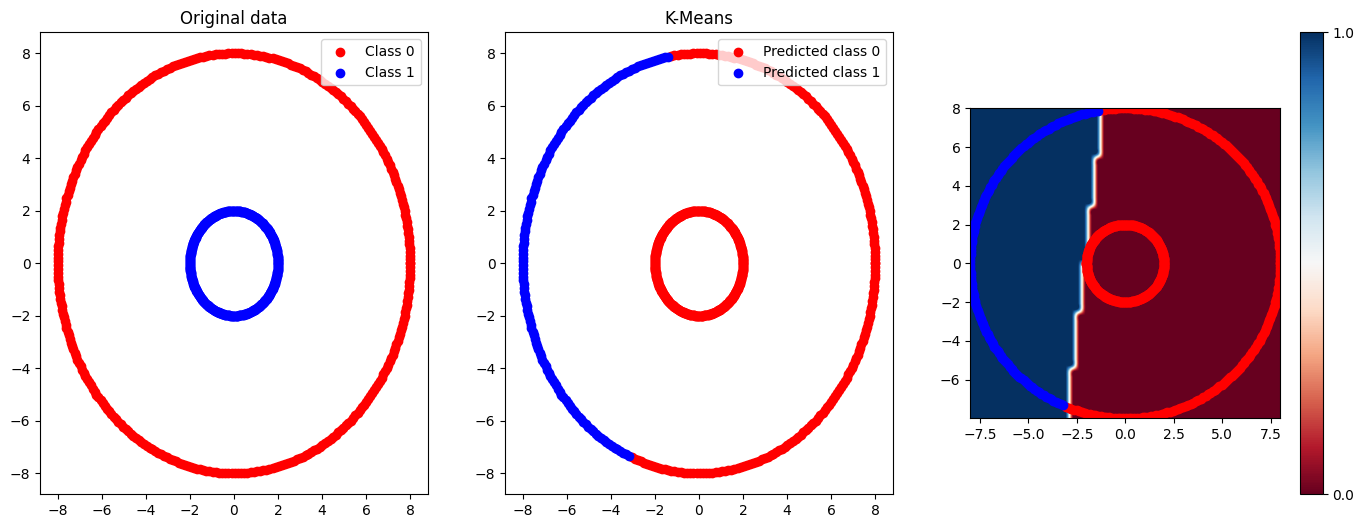

In [27]:
for iteration, scenarioIndex in enumerate(range(1, 5)):
    X0,X1,y = generate_scenario(scenario=scenarioIndex, n_samples0 = 350, n_samples1 = 350)
    X=np.concatenate((X0,X1),axis=0)
    
    ## K-means
    Ncluster= 2 # choose a number of clusters
    kmeans=KMeans(n_clusters=Ncluster) 
    yKmeans=kmeans.fit_predict(X)
    
    plt.figure(figsize=(17, 6))
    plt.subplot(131)
    plt.scatter(X[np.where(y == 0)[0],0],X[np.where(y == 0)[0],1],c='r', label='Class 0')
    plt.scatter(X[np.where(y == 1)[0],0],X[np.where(y == 1)[0],1],c='b', label='Class 1')
    plt.title('Original data')
    plt.legend()
    
    plt.subplot(132)
    plt.scatter(X[np.where(yKmeans == 0)[0],0],X[np.where(yKmeans == 0)[0],1],c='r', label='Predicted class 0')
    plt.scatter(X[np.where(yKmeans == 1)[0],0],X[np.where(yKmeans == 1)[0],1],c='b', label='Predicted class 1')
    plt.title('K-Means')
    plt.legend()
    
    plt.subplot(133)
    frontiere(kmeans, X, y, step=50)
    
    plt.show()

Now, implement your own K-means using the Lloyd's algorithm.

In [28]:

#def KMeansLecture(X,K=2,tol=1e-4):
#    XXXXXXXX
#    XXXXXXXX
#    XXXXXXXX
#    XXXXXXXX
#    XXXXXXXX
#    #...
#    XXXXXXXX
#    XXXXXXXX
#    XXXXXXXX
#    
#    
#    return yKmeans,muTab

def KMeansLecture(X, K=2, tol=1e-4):
    """
    Performs K-means clustering on the input data X.

    Args:
        X (numpy.ndarray): Input data matrix with shape (N, D), where N is the number of samples and D is the dimensionality.
        K (int, optional): Number of clusters. Defaults to 2.
        tol (float, optional): Tolerance for convergence. Defaults to 1e-4.

    Returns:
        yKmeans (numpy.ndarray): Cluster assignments for each sample (shape: (N,)).
        muTab (numpy.ndarray): Final cluster centroids (shape: (K, D)).
    """
    N, D = X.shape
    # Initialize cluster centroids randomly
    muTab = np.random.rand(K, D)
    prev_muTab = np.zeros_like(muTab)

    while np.linalg.norm(muTab - prev_muTab) > tol:
        # Assign each sample to the nearest centroid
        dists = np.linalg.norm(X[:, np.newaxis] - muTab, axis=2)
        yKmeans = np.argmin(dists, axis=1)

        # Update centroids
        prev_muTab = muTab.copy()
        for k in range(K):
            muTab[k] = np.mean(X[yKmeans == k], axis=0)

    return yKmeans, muTab


Now, test your K-means algorithm.

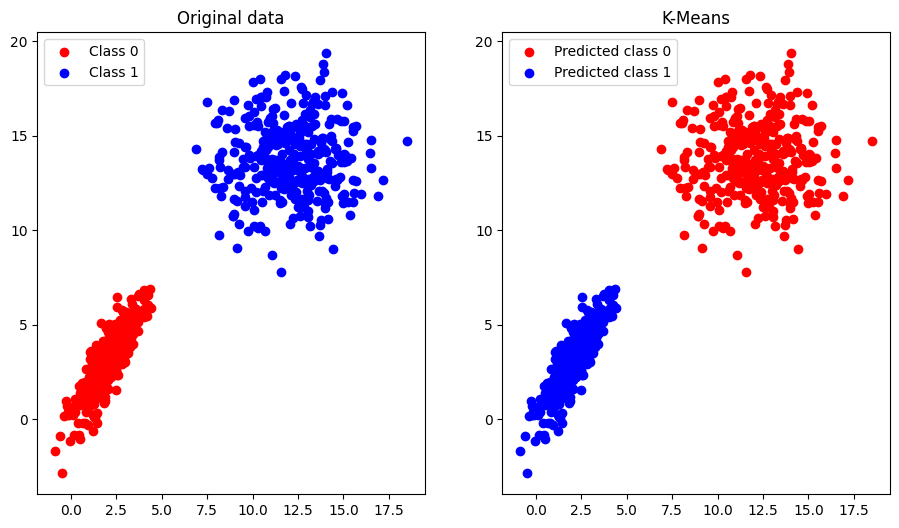

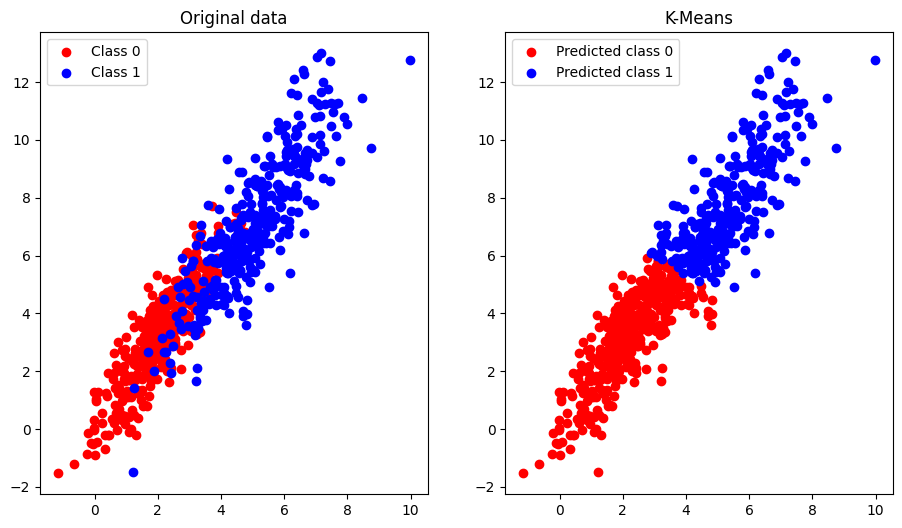

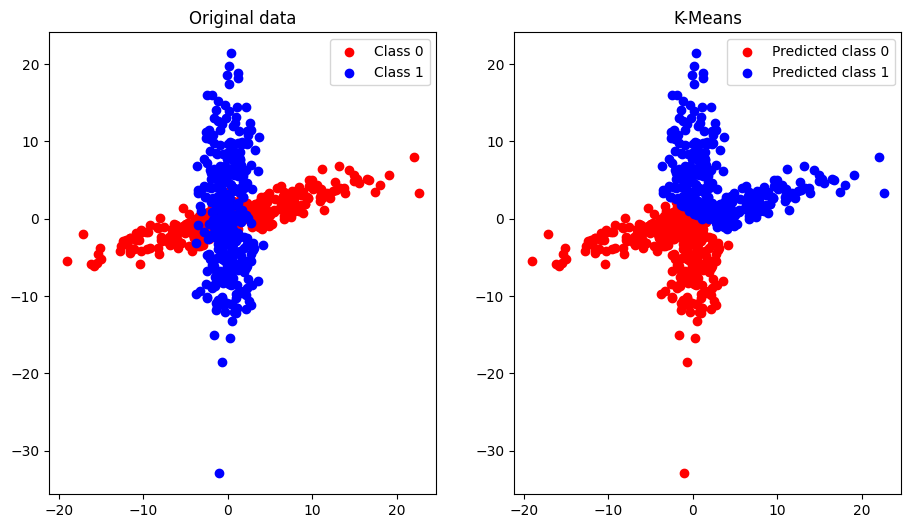

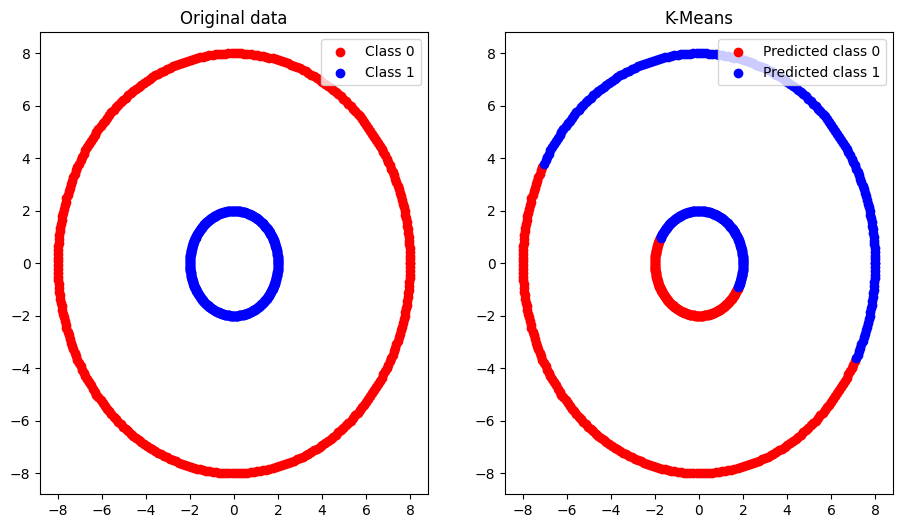

In [29]:
for iteration, scenarioIndex in enumerate(range(1, 5)):
    X0,X1,y = generate_scenario(scenario=scenarioIndex, n_samples0 = 350, n_samples1 = 350)
    X=np.concatenate((X0,X1),axis=0)

    ## K-means
    Ncluster= 2 # choose a number of clusters
    yKmeans,muTab = KMeansLecture(X,K=Ncluster,tol=1e-4)
    
    plt.figure(figsize=(17, 6))
    plt.subplot(131)
    plt.scatter(X[np.where(y == 0)[0],0],X[np.where(y == 0)[0],1],c='r', label='Class 0')
    plt.scatter(X[np.where(y == 1)[0],0],X[np.where(y == 1)[0],1],c='b', label='Class 1')
    plt.title('Original data')
    plt.legend()
    
    plt.subplot(132)
    plt.scatter(X[np.where(yKmeans == 0)[0],0],X[np.where(yKmeans == 0)[0],1],c='r', label='Predicted class 0')
    plt.scatter(X[np.where(yKmeans == 1)[0],0],X[np.where(yKmeans == 1)[0],1],c='b', label='Predicted class 1')
    plt.title('K-Means')
    plt.legend()

## II-2) K-means for skin lesion segmentation


In this section, you will use the K-means to segment skin lesion images. You will use two images from the ISIC dataset (www.isic-archive.com), one nevus and one melanoma with their respetive manual segmentation. 

**Goal**

The goal of this section is to delineate the contours (i.e. segment) of the skin lesions using k-means. 

Let's first load the data. The images are rescaled so that the computations are faster.

You are not using Colab. Please define working_dir with the absolute path to the folder where you downloaded the data


(-0.5, 374.5, 280.5, -0.5)

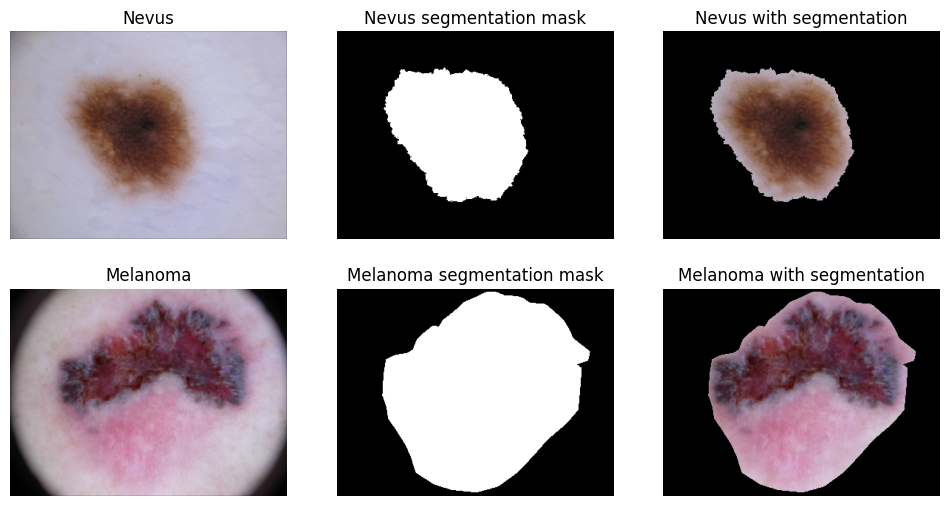

In [6]:
if 'google.colab' in str(get_ipython()):
  from google_drive_downloader import GoogleDriveDownloader as gdd
  gdd.download_file_from_google_drive(file_id='1_TeYzLLDoKbPX4xXAOAM_mQiT2nLHgvp',
  dest_path='./data/nevus.jpg')
  gdd.download_file_from_google_drive(file_id='1iQZdUiuK_FwZ7mik7LB3eN_H_IUc5l7b',
  dest_path='./data/nevus-seg.jpg')
  gdd.download_file_from_google_drive(file_id='1yZ46UzGhwO7g5T8397JpewBl6UqgRo5J',
  dest_path='./data/melanoma.jpg')
  gdd.download_file_from_google_drive(file_id='1B2Ol92mBcHN6ah3bpoucBbBbHkPMGC8D',
  dest_path='./data/melanoma-seg.png')
else:
  print('You are not using Colab. Please define working_dir with the absolute path to the folder where you downloaded the data')

# Please modify working_dir only if you are using your Anaconda (and not Google Colab)
Working_directory="./data/" 




# Nevus
nevus = imread(Working_directory + 'nevus.jpg')
nevus=nevus[2:-2,2:-2,:] # remove border (it contains artifacts)
nevusMask = imread(Working_directory + 'nevus-seg.jpg')
nevusMask=nevusMask[2:-2,2:-2] # remove border (it contains artifacts)
# We rescale to speed up computations
nevus = rescale(nevus, 0.25, channel_axis = 2,anti_aliasing=True)
# We need all these options to preserve the binary values
nevusMask = rescale(nevusMask, 0.25, anti_aliasing=False, order=0,  preserve_range=True)
nevusMask_boolean = (nevusMask/255).astype(np.uint8) # To get uint8
nevusMask_expand = np.expand_dims(nevusMask_boolean, axis=2) # To have a 3 channels boolean mask

# Melanoma
melanoma = imread(Working_directory + 'melanoma.jpg')
melanoma=melanoma[2:-2,2:-2,:] # remove border (it contains artifacts)
melanomaMask = imread(Working_directory + 'melanoma-seg.png')
melanomaMask=melanomaMask[2:-2,2:-2] # remove border (it contains artifacts)
melanoma = rescale(melanoma, 0.25, channel_axis = 2,anti_aliasing=True)
melanomaMask = rescale(melanomaMask, 0.25, anti_aliasing=False, order=0,  preserve_range=True)
melanomaMask_boolean = (melanomaMask/255).astype(np.uint8) 
melanomaMask_expand = np.expand_dims(melanomaMask_boolean, axis=2)

fig = plt.figure(figsize=(12, 12))
grid = AxesGrid(fig, 111,
                nrows_ncols = (2, 3),
                axes_pad = 0.5)
grid[0].imshow(nevus)
grid[0].set_title('Nevus')
grid[0].axis('off')
grid[1].imshow(nevusMask_boolean,cmap='gray')
grid[1].set_title('Nevus segmentation mask')
grid[1].axis('off')
grid[2].imshow(nevusMask_expand*nevus)
grid[2].set_title('Nevus with segmentation')
grid[2].axis('off')
grid[3].imshow(melanoma)
grid[3].set_title('Melanoma')
grid[3].axis('off')
grid[4].imshow(melanomaMask_boolean,cmap='gray')
grid[4].set_title('Melanoma segmentation mask')
grid[4].axis('off')
grid[5].imshow(melanomaMask_expand*melanoma)
grid[5].set_title('Melanoma with segmentation')
grid[5].axis('off')



**Questions**

1. Before running K-means, please answer this question. How many classes $K$ should you look for ? Would you use the same $K$ for both images ? Why ?


2. Run the following code for both images. Try to choose different channels (among the channels Red, Green and Blue) and different number of clusters $K$. Which is the best choice in terms of channel and number of classes ? You can use the [Dice score](https://en.wikipedia.org/wiki/S%C3%B8rensen%E2%80%93Dice_coefficient) to quantitatively compare your mask and the manual segmentation. Comment the results with respect to the previous answer.

The dice score (or dice similarity) between two binary masks is defined as $\frac{2TP}{2TP + FP + FN}$ and it ranges between 0 (completely different) and 1 (perfectly equal).

3. In K-means, we recompute the average at each iteration. The average is not constrained to be one of the original observations. It is usually an *interpolation* of the original observations. How would you change the Lloyd's algorithm to constrain the average to always be one of the original observations ?

**Answers**
1. For the Nevus i would choose 2 clusters: 1 for the skin region without nevus, 1 for the nevus region.

For the Melanoma i would choose 2 or 3 clusters: 1 for the skin region without melanomano, 1 or 2 for the melanoma region (it may be 2 since the colors of the melanoma region is not uniform)

2. I did two for loops (one for the channel and one for the clusters) for both images and got the following results

Nevus best channel: 2

Nevus best number of clusters:2

Melanoma best channel: 0

Melanoma best number of clusters:3

It makes sense according to the answer 1

3. Then, it wouldn't be k-means but more similar to the k-medoids algorithm that operates by identifying medoids that minimize the total dissimilarities between data points and their nearest medoid. A medoid, within a set, is a member that exhibits the least average dissimilarity with the other members of the set. (code is given in the last cell)

2
The dice score is  0.8296033581000696
Number of clusters: 2
Selected channel: 2


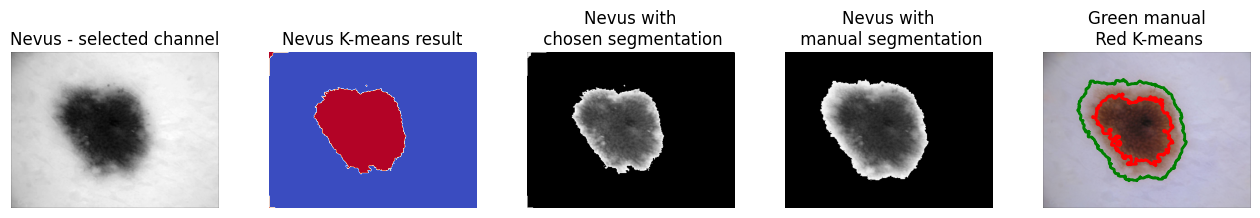

In [7]:
## NEVUS
# Select a channel (0 for Red, 1 for Green and 2 for Blue)
# Define the range of channels
channel_range = range(3)
# Number of clusters to try (between 2 and 5)
num_clusters_range = range(2, 6)
best_channel = None
best_dice_score = 0
best_num_clusters = None
best_labels = None
best_mask = None

for channel in channel_range:
    # NEVUS data processing for the current channel
    nevusB = nevus[:, :, channel]
    

    # Iterate over number of clusters and channels
    for K in num_clusters_range:
    
        kmeans=KMeans(n_clusters=K, random_state=1) 
        labels=kmeans.fit_predict(nevusB.reshape(-1,1))
        labels=np.reshape(labels,(nevusB.shape[0],nevusB.shape[1]))
        
        # Depending on the number of classes K, K-means returns one integer per pixel 
        # which indicates the number of the cluster. 
        # Choose the integer to use as mask between 0 and K-1
        index =1
        mask=labels==index ## choose which label should be

        dice_score = 1-dice(np.squeeze(nevusMask_boolean.reshape(1,-1)), np.squeeze(mask.reshape(1,-1)))

        # Update best parameters if current score is better
        if dice_score > best_dice_score:
            best_dice_score = dice_score
            best_num_clusters = K
            best_labels = labels
            best_mask = mask
            best_channel = channel
			
contourMask = find_contours(mask, 0.5)
contourManual = find_contours(nevusMask_boolean, 0.5)
print(best_channel)
# plot the results
fig = plt.figure(figsize=(16, 12))
grid = AxesGrid(fig, 111,
                nrows_ncols = (1, 5),
                axes_pad = 0.5)
grid[0].imshow(nevus[:, :, best_channel],cmap='gray')
grid[0].set_title('Nevus - selected channel')
grid[0].axis('off')
grid[1].imshow(best_labels,cmap='coolwarm')
grid[1].set_title('Nevus K-means result')
grid[1].axis('off')
grid[2].imshow(best_mask*nevusB,cmap='gray')
grid[2].set_title('Nevus with\n chosen segmentation')
grid[2].axis('off')
grid[3].imshow(nevusMask_boolean*nevusB,cmap='gray')
grid[3].set_title('Nevus with\n manual segmentation')
grid[3].axis('off')
grid[4].imshow(nevus)
for contour in contourMask:
  grid[4].plot(contour[:, 1], contour[:, 0], linewidth=2, c='r')
for contour in contourManual:
  grid[4].plot(contour[:, 1], contour[:, 0], linewidth=2, c='g')
grid[4].set_title('Green manual\n Red K-means')
grid[4].axis('off')

# Compute the dice score between your mask and the manual segmentation 
print('The dice score is ', best_dice_score)
print('Number of clusters:', best_num_clusters)
print('Selected channel:', best_channel)

The dice score is  0.58292348233694
Number of clusters: 3
Selected channel: 0


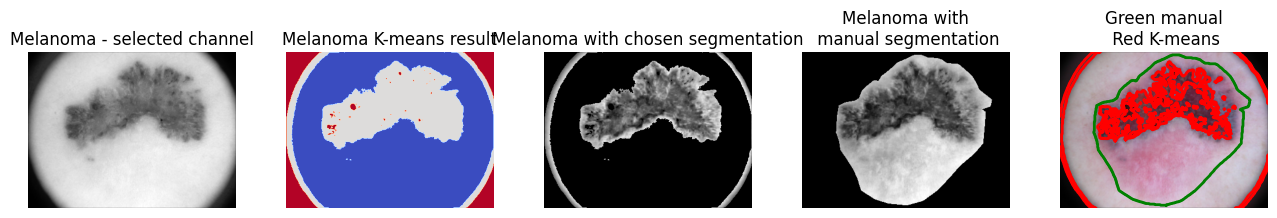

In [16]:
## MELANOMA
# Select a channel (0 for Red, 1 for Green and 2 for Blue)
# Define the range of channels
channel_range = range(3)
# Number of clusters to try (between 2 and 5)
num_clusters_range = range(2, 6)
best_channel = None
best_dice_score = 0
best_num_clusters = None
best_labels = None
best_mask = None

for channel in channel_range:
	
##
    melanomaB = melanoma[:,:,channel]

    for K in num_clusters_range:

        ##
        kmeans=KMeans(n_clusters=K) 
        labels=kmeans.fit_predict(melanomaB.reshape(-1,1))
        labels=np.reshape(labels,(melanomaB.shape[0],melanomaB.shape[1]))
        
        # Depending on the number of classes K, K-means returns one integer per pixel 
        # which indicates the number of the cluster. 
        # Choose the integer to use as mask between 0 and K-1
        index =1
        mask=labels==index ## choose which label should be

        dice_score = 1-dice(np.squeeze(melanomaMask_boolean.reshape(1,-1)), np.squeeze(mask.reshape(1,-1)))

        # Update best parameters if current score is better
        if dice_score > best_dice_score:
            best_dice_score = dice_score
            best_num_clusters = K
            best_labels = labels
            best_mask = mask
            best_channel = channel

contourMask = find_contours(mask, 0.5)
contourManual = find_contours(melanomaMask_boolean, 0.5)

fig = plt.figure(figsize=(16, 12))
grid = AxesGrid(fig, 111,
                nrows_ncols = (1, 5),
                axes_pad = 0.5)
grid[0].imshow(melanoma[:,:,best_channel],cmap='gray')
grid[0].set_title('Melanoma - selected channel')
grid[0].axis('off')
grid[1].imshow(best_labels,cmap='coolwarm')
grid[1].set_title('Melanoma K-means result')
grid[1].axis('off')
grid[2].imshow(best_mask*melanomaB,cmap='gray')
grid[2].set_title('Melanoma with chosen segmentation')
grid[2].axis('off')
grid[3].imshow(melanomaMask_boolean*melanomaB,cmap='gray')
grid[3].set_title('Melanoma with\n manual segmentation')
grid[3].axis('off')
grid[4].imshow(melanoma)
for contour in contourMask:
  grid[4].plot(contour[:, 1], contour[:, 0], linewidth=2, c='r')
for contour in contourManual:
  grid[4].plot(contour[:, 1], contour[:, 0], linewidth=2, c='g')
grid[4].set_title('Green manual\n Red K-means')
grid[4].axis('off')

# Compute the dice score between your mask and the manual segmentation 
print('The dice score is ', best_dice_score)
print('Number of clusters:', best_num_clusters)
print('Selected channel:', best_channel)

In [33]:
def KMeansLecture(X, K=2, tol=1e-4):
    """
    Performs K-means clustering on the input data X.

    Args:
        X (numpy.ndarray): Input data matrix with shape (N, D), where N is the number of samples and D is the dimensionality.
        K (int, optional): Number of clusters. Defaults to 2.
        tol (float, optional): Tolerance for convergence. Defaults to 1e-4.

    Returns:
        yKmeans (numpy.ndarray): Cluster assignments for each sample (shape: (N,)).
        muTab (numpy.ndarray): Final cluster centroids (shape: (K, D)).
    """
    N, D = X.shape
    # Initialize cluster centroids randomly
    muTab = X[np.random.choice(N, K, replace=False)]  # Initialize centroids as random data points
    prev_muTab = np.zeros_like(muTab)

    while np.linalg.norm(muTab - prev_muTab) > tol:
        # Assign each sample to the nearest centroid
        dists = np.linalg.norm(X[:, np.newaxis] - muTab, axis=2)
        yKmeans = np.argmin(dists, axis=1)

        # Update centroids to be one of the original observations within the cluster
        prev_muTab = muTab.copy()
        for k in range(K):
            cluster_points = X[yKmeans == k]
            if len(cluster_points) > 0:
                closest_point_index = np.argmin(np.linalg.norm(cluster_points - muTab[k], axis=1))
                muTab[k] = cluster_points[closest_point_index]

    return yKmeans, muTab
